# Project 11

## Project description

A startup company that sells food products. Need to research user behavior for the company's application.

First, study the sales funnel. Find out how users reach the purchase stage. How many users actually reach this stage? How many get stuck in earlier stages? Which specific stages?

Then, take a look at the results of an A/A/B test (*keep reading to learn more about A/A/B test*). The design team would like to change the fonts throughout the entire app, but management fears that users may find the new design intimidating. For this reason, they've decided to make a decision based on the results of an A/A/B test.

Users are divided into **three groups**: two control groups get the old fonts, and one test group gets the new fonts. Determine which set of fonts produces better results.

Creating two A groups has certain advantages. We can establish the principle that we'll only trust the accuracy of our tests when both control groups are similar. If there are significant differences between the A groups, this may help us identify factors that could be skewing the results. Comparing control groups also tells us how much time and data we'll need when conducting future tests.

You'll use the same dataset for both the general analysis and the A/A/B test analysis. In real projects, experiments are carried out continuously. The analytics team studies app quality using general data, without paying attention to whether users are participating in experiments.

## Step 1. Open the data file and read the information

### Load data and read general information

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
#General display settings
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### Read data

In [7]:
#data = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')
data = pd.read_csv(r'D:/2. Objetivos especificos/9. Programación/notebooks_de_jupiter/sprint_11/logs_exp_us.csv', sep= '\t')

In [ ]:
print(data.sample(5))

                      EventName         DeviceIDHash  EventTimestamp  ExpId
14632          MainScreenAppear  5240727563879855374      1564655892    248
234931  PaymentScreenSuccessful   652742507219479167      1565192716    248
220871         MainScreenAppear  4229497205630462633      1565168201    248
76048          MainScreenAppear   634894491679664239      1564806326    246
176553         CartScreenAppear  3788810404193836212      1565041790    247


## Step 2. Prepare the data

In [ ]:
#Rename columns
columns_rename = {
    'EventName': 'event',
    'DeviceIDHash':'user_id',
    'EventTimestamp':'timestamp',
    'ExpId':'exp_id'
}
data = data.rename(columns = columns_rename)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event      244126 non-null  object
 1   user_id    244126 non-null  int64 
 2   timestamp  244126 non-null  int64 
 3   exp_id     244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [ ]:
data['timestamp'].head()

0    1564029816
1    1564053102
2    1564054127
3    1564054127
4    1564055322
Name: timestamp, dtype: int64

In [ ]:
#Convert types
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')


In [ ]:
data['date'] = data['timestamp'].dt.date

In [ ]:
print(data)

                          event              user_id           timestamp  \
0              MainScreenAppear  4575588528974610257 2019-07-25 04:43:36   
1              MainScreenAppear  7416695313311560658 2019-07-25 11:11:42   
2       PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47   
3              CartScreenAppear  3518123091307005509 2019-07-25 11:28:47   
4       PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42   
...                         ...                  ...                 ...   
244121         MainScreenAppear  4599628364049201812 2019-08-07 21:12:25   
244122         MainScreenAppear  5849806612437486590 2019-08-07 21:13:59   
244123         MainScreenAppear  5746969938801999050 2019-08-07 21:14:43   
244124         MainScreenAppear  5746969938801999050 2019-08-07 21:14:58   
244125       OffersScreenAppear  5746969938801999050 2019-08-07 21:15:17   

        exp_id        date  
0          246  2019-07-25  
1          246  2019-07-25  


## Step 3. Study and verify the data

In [ ]:
print('Eventos totales:', len(data))
print('Usuarios únicos:', data['user_id'].nunique())
print('Eventos promedio por usuario:', data.groupby('user_id')['event'].count().mean())

print('Primer evento:', data['timestamp'].min())
print('Ultimo evento:', data['timestamp'].max())

Eventos totales: 244126
Usuarios únicos: 7551
Eventos promedio por usuario: 32.33028737915508
Primer evento: 2019-07-25 04:43:36
Ultimo evento: 2019-08-07 21:15:17


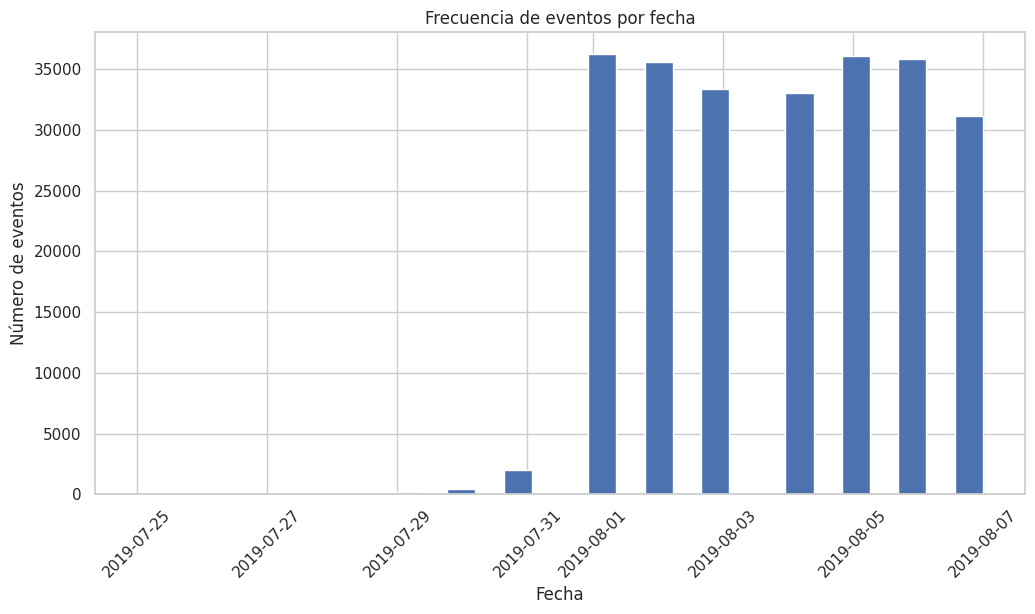

In [ ]:
# Histograma por fecha
plt.hist(data['date'], bins=30)
plt.title('Frecuencia de eventos por fecha')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Identify the date from which the data is complete
cutoff_date = pd.to_datetime('2019-08-01')
data = data[data['timestamp'] >= cutoff_date]
print('Datos filtrados desde:', cutoff_date.date())

Datos filtrados desde: 2019-08-01


In [ ]:
# Review experimental groups
print('Distribución por grupo:')
print(data['exp_id'].value_counts())

Distribución por grupo:
248    84726
246    79425
247    77147
Name: exp_id, dtype: int64


A total of 244,126 events were recorded, corresponding to 7,551 unique users. This suggests a relatively small user base, but with high individual activity: each user performed an average of 32 events.

Analyzing the dates, the data spans from July 25 to August 7, 2019. However, the frequency histogram reveals that the data is consistent only between August 1 and 7, with a notable absence of events on August 4. Despite this specific gap, the information can be considered reliable for this period.

However, events prior to August 1, 2019, are incomplete and scattered, so it was decided to filter the data from that date onward to ensure quality and consistency in the analysis.

Finally, reviewing the distribution of users across the experimental groups (ExpId) confirms that, even after filtering, each group retains a sufficient number of events, allowing the study to continue properly.

## Step 4. Funnel Study

In [ ]:
#Eventos ordenados por frecuencia
event_freq = data['event'].value_counts()
print('Eventos ordenados por frecuencia:\n', event_freq)

Eventos ordenados por frecuencia:
 MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event, dtype: int64


In [ ]:
# Usuarios por evento
users_per_event = data.groupby('event')['user_id'].nunique().sort_values(ascending=False)
print('\nUsuarios por evento:\n', users_per_event)

# Proporción de usuarios que realizaron cada evento
total_users = data['user_id'].nunique()
print("\nProporciones de usuarios por evento:\n", (users_per_event / total_users).round(3))

# Embudo
funnel_events = users_per_event.index.tolist()
funnel = users_per_event[funnel_events].copy()
conversion_rates = funnel / funnel.iloc[0]
print('\nTasas de conversión por etapa:\n', conversion_rates.round(3))



Usuarios por evento:
 event
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64

Proporciones de usuarios por evento:
 event
MainScreenAppear           0.985
OffersScreenAppear         0.610
CartScreenAppear           0.496
PaymentScreenSuccessful    0.470
Tutorial                   0.111
Name: user_id, dtype: float64

Tasas de conversión por etapa:
 event
MainScreenAppear           1.000
OffersScreenAppear         0.619
CartScreenAppear           0.503
PaymentScreenSuccessful    0.477
Tutorial                   0.113
Name: user_id, dtype: float64


An analysis of the recorded events reveals a main flow that users follow during the checkout process:

- MainScreenAppear
- OffersScreenAppear
- CartScreenAppear
- PaymentScreenSuccessful

On the other hand, the Tutorial event appears to be outside the main flow, as it represents a complementary interaction. Users likely access this option due to questions about the checkout process or by mistake.

Looking at the proportion of users participating in each stage, the following conversion rates between events are identified:

More than 98% of users start at MainScreenAppear.

This proportion drops to approximately 61% at OffersScreenAppear.

It then drops to 49% at CartScreenAppear.

Finally, it remains stable at around 47% when reaching PaymentScreenSuccessful.

This data suggests that most users who reach the cart stage (CartScreenAppear) are engaged and have a high probability of completing the purchase.

However, the most critical point of attrition occurs between MainScreenAppear and OffersScreenAppear, where the most significant drop in engagement is observed. Improving this transition represents a key opportunity: if more users can advance to the offers stage, conversions in later stages of the funnel are also likely to increase.

## Step 5. Study the experiment

In [ ]:
# Users per group
users_by_group = data.groupby('exp_id')['user_id'].nunique()
print('\nUsuarios por grupo:\n', users_by_group)


Usuarios por grupo:
 exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


In [ ]:
from scipy.stats import norm
import numpy as np

def compare_proportions(event, group1, group2):
    # Conteos de usuarios por evento y grupo
    users_event_1 = data[(data['exp_id'] == group1) & (data['event'] == event)]['user_id'].nunique()
    users_total_1 = data[data['exp_id'] == group1]['user_id'].nunique()

    users_event_2 = data[(data['exp_id'] == group2) & (data['event'] == event)]['user_id'].nunique()
    users_total_2 = data[data['exp_id'] == group2]['user_id'].nunique()

    # Proporciones
    p1 = users_event_1 / users_total_1
    p2 = users_event_2 / users_total_2

    # Proporción combinada
    p_combined = (users_event_1 + users_event_2) / (users_total_1 + users_total_2)

    # Estadístico z
    diff = p1 - p2
    std_error = np.sqrt(p_combined * (1 - p_combined) * (1/users_total_1 + 1/users_total_2))
    z_score = diff / std_error

    # p-valor (dos colas)
    pval = 2 * (1 - norm.cdf(abs(z_score)))

    return round(pval, 4)
 



In [ ]:
# Compare control groups (246 and 247)
print('\nComparación entre grupos de control:')
for event in users_per_event.index:
    p_value = compare_proportions(event, 246, 247)
    print(f"Evento: {event}, p-valor: {p_value}")

# Compare test group (248) vs each control
print('\nComparación grupo de prueba vs controles:')
for event in users_per_event.index:
    p_value_1 = compare_proportions(event, 248, 246)
    p_value_2 = compare_proportions(event, 248, 247)
    print(f"Evento: {event}, vs 246 p={p_value_1} | vs 247 p={p_value_2}")

#Adjustment for multiple tests
print('\nTotal de pruebas realizadas:', len(users_per_event.index)*3)
print('Con un nivel de significancia de 0.1, se podrían esperar falsos positivos.')

    


Comparación entre grupos de control:
Evento: MainScreenAppear, p-valor: 0.7571
Evento: OffersScreenAppear, p-valor: 0.2481
Evento: CartScreenAppear, p-valor: 0.2288
Evento: PaymentScreenSuccessful, p-valor: 0.1146
Evento: Tutorial, p-valor: 0.9377

Comparación grupo de prueba vs controles:
Evento: MainScreenAppear, vs 246 p=0.295 | vs 247 p=0.4587
Evento: OffersScreenAppear, vs 246 p=0.2084 | vs 247 p=0.9198


### Conclusion of the Statistical Significance Analysis Comparison between control groups (A/A test):

Five hypothesis tests were conducted to compare the events between the control groups (ExpId 246 and 247).
The p-values ​​obtained for each event were all greater than 0.1, indicating no statistically significant differences between the two control groups.
This confirms that the allocation between the groups was adequate and that the system for assigning users to the experiment is reliable.


### Comparison of the test group (ExpId 248) with the control groups:

Ten additional tests were performed to compare the experimental group against each control group separately.
In all cases, the p-values ​​were also greater than 0.1, with a single marginal exception:

CartScreenAppear vs. group 246: p = 0.0784

Although this value is below the threshold of 0.1, a significant difference cannot be concluded without adjusting for multiple comparisons.

### Consideration of multiple tests (15 in total):


With 15 tests and a significance level of 0.1, we could expect up to 1.5 false positives due to chance. Therefore, it is advisable to apply a correction for multiple comparisons, such as the Bonferroni correction.

Using Bonferroni, the adjusted threshold would be:
0.1 / 15 ≈ 0.0067

No p-value is lower than this new threshold; therefore, there is no statistically significant evidence that the experimental group differs from the control groups.


### General conclusion

The A/A test was successful: the control groups showed no differences, validating the experiment's methodology.

The experimental group showed no significant differences in the main events compared to the controls.

No significant effects of the experiment on user behavior were observed in any of the stages analyzed.

Next step: It could be concluded that the experiment had no measurable impact, or that more data or a redesign of the intervention is needed to generate an observable effect.